<a href="https://www.nvidia.com/en-us/deep-learning-ai/education/"> <img src="images/DLI Header.png" alt="Header" style="width: 400px;"/> </a>

# 第2部分：用于医学深度学习的数据科学工具

虽然我们已经训练了神经网络，但在这个部分我们将专注于创建和验证扩充的数据集。我们知道，上一节中的神经网络经过训练后，能够在MedNIST上产生98.3~99.6％的准确性。 <b>因此，如果我们的数据扩充（亦称数据增强）技术很强健，那么在扩充数据集上进行训练时，我们应该能够看到相近的准确性。</b>

如果我们只能重现在某些原始数据集上的准确性，那进行数据扩充又有什么意义呢？然而，假设我们原来只有一个小型数据集，具有与MedNIST相似的类型。因为我们在MedNIST上已经验证了扩增过程的准确性，所以我们可以将相同的技术应用于这些与MedNIST相似的图像，并可确信扩充后的数据集也是强健的。 <b>因此，验证数据增强技术的一般工作流程是，先在大型数据集上开发出数据增强过程，然后将这个过程移至具有类似数据结构的较小数据集，用它来生成新数据，而无需额外的“事实真相”（ground truth）标注。</b>

我们将指导您完成一系列基本练习，实现影像数据集的扩充与归一化。尽管这些步骤并非适用于所有任务，但此过程类似于您准备数据时所常用的过程。在练习的最后，您将能够下载已创建的扩充数据集，以用于您自己的深度学习项目。

我们首先导入库并重新加载此笔记本的数据。

In [1]:
import numpy as np
import os
import time
%matplotlib inline
import matplotlib.pyplot as mp
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as om
import torchvision as tv
import torch.utils.data as dat

# confusion matrix plotting
from sklearn.metrics import confusion_matrix, accuracy_score
from mlxtend.plotting import plot_confusion_matrix

if torch.cuda.is_available():     # Make sure GPU is available
    dev = torch.device("cuda:0")
    kwar = {'num_workers': 8, 'pin_memory': True}
    cpu = torch.device("cpu")
else:
    print("Warning: CUDA not found, CPU only.")
    dev = torch.device("cpu")
    kwar = {}
    cpu = torch.device("cpu")

np.random.seed(551)

如果要删除先前运行中创建的增强数据集并从头开始，请取消注释并执行以下单元格。

In [2]:
## Run this if you want to remove augmented data
# !rm -r data/resized
# !cp -r data/resizedbackup data/resized

In [3]:
dataDir = 'data/resized'               # The main data directory
classNames = os.listdir(dataDir)  # Each type of image can be found in its own subdirectory
numClass = len(classNames)        # Number of types = number of subdirectories
imageFiles = [[os.path.join(dataDir,classNames[i],x) for x in os.listdir(os.path.join(dataDir,classNames[i]))]
              for i in range(numClass)]                     # A nested list of filenames
numEach = [len(imageFiles[i]) for i in range(numClass)]     # A count of each type of image
imageFilesList = []               # Created an un-nested list of filenames
imageClass = []                   # The labels -- the type of each individual image in the list
for i in range(numClass):
    imageFilesList.extend(imageFiles[i])
    imageClass.extend([i]*numEach[i])
numTotal = len(imageClass)        # Total number of images
imageWidth, imageHeight = Image.open(imageFilesList[0]).size         # The dimensions of each image

print("There are",numTotal,"images in",numClass,"distinct categories")
print("Label names:",classNames)
print("Label counts:",numEach)
print("Image dimensions:",imageWidth,"x",imageHeight)

There are 58954 images in 6 distinct categories
Label names: ['CXR', 'ChestCT', 'Hand', 'BreastMRI', 'HeadCT', 'AbdomenCT']
Label counts: [10000, 10000, 10000, 8954, 10000, 10000]
Image dimensions: 64 x 64


## 数据集的扩充（增强）

我们将尝试使用数据增强技术以使每个类别中的图像数量归一化。不过，先让我们看一下已有的一些图像。下面的代码块可以多次运行以随机抽取不同的图像。

### 代码块1

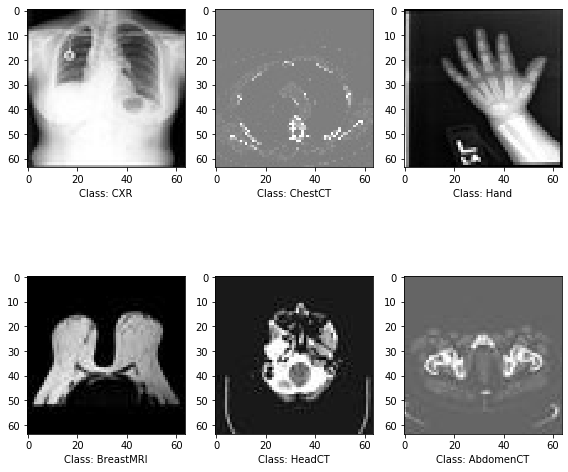

In [4]:
mp.subplots(3,2,figsize=(8,8))
for i in range(numClass): 
    im = Image.open(imageFiles[i][np.random.randint(numEach[i])])   # Randomly sample one image per class
    arr = np.array(im)
    mp.subplot(2,3,i+1)
    mp.xlabel('Class: '+classNames[i])
    mp.imshow(arr,cmap='gray',vmin=0,vmax=255)
mp.tight_layout()
mp.show()

请注意，某些图像的像素值缩放比例与其它图像不同，亦即，它们的最大和最小亮度不同。在执行最后一组数据增强操作时，我们将对图像的亮度进行归一化。

现在让我们探讨一下在不考虑这种重新缩放过程的情况下如何进行一些各种不同的图像变换。我们从`RandomRotation`开始。顾名思义，RandomRotation可以将图像旋转一个随机的角度，但在任一方向都不超过某个设定的最大角度。下面的显示中，未旋转过的图像出现在左上角。

#### 练习：
请尝试使用不同的最大旋转值（更改`maxRot`的值）在下面多次重新运行代码块。

### 代码块2

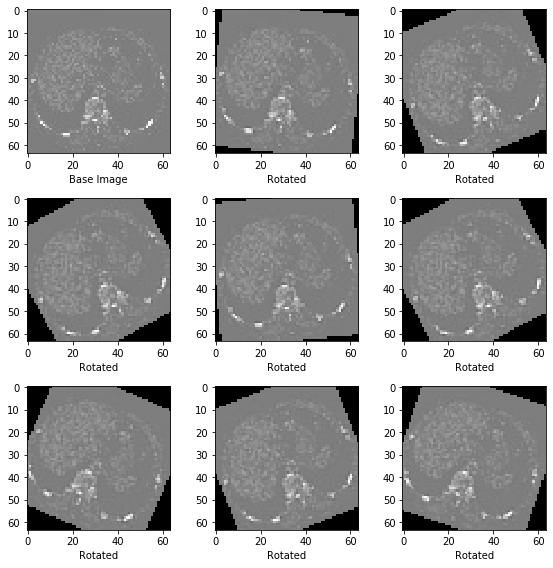

In [5]:
maxRot = 30
randRot = tv.transforms.RandomRotation(maxRot,resample=Image.BICUBIC)
baseImage = Image.open(imageFiles[np.random.randint(6)][np.random.randint(8000)])
mp.subplots(3,3,figsize=(8,8))
mp.subplot(3,3,1)
mp.xlabel('Base Image')
mp.imshow(np.array(baseImage),cmap='gray',vmin=0,vmax=255)
for i in range(8):
    randImage = randRot(baseImage)
    # tv.transforms.RandomRotation(maxRot,resample=Image.BICUBIC)(baseImage)
    mp.subplot(3,3,i+2)
    mp.xlabel('Rotated')
    mp.imshow(np.array(randImage),cmap='gray',vmin=0,vmax=255)
mp.tight_layout()
mp.show()

我们也可以尝试对图像进行随机平移，这是通过`RandomAffine`函数执行的。该函数包括更通用的变换类型（旋转，平移，剪切，缩放），但其余选项在此例中均已关闭。

平移的大小是整个图像尺寸的分数值（取0到1的一个值），并可以将x和y方向的平移设置为不同的值。

#### 练习：
使用`maxTrX`和/或`maxTrY`的几个不同值重新运行下面的代码块。

### 代码块3

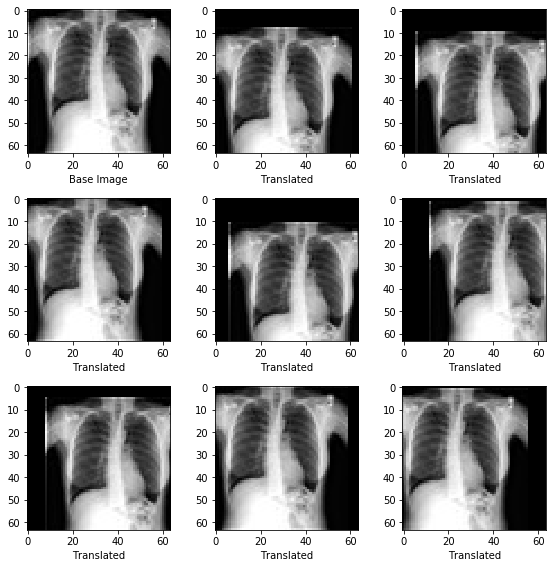

In [6]:
maxTrX = 0.2
maxTrY = 0.2
randTr = tv.transforms.RandomAffine(0,translate=(maxTrX,maxTrY),resample=Image.BICUBIC)
baseImage = Image.open(imageFiles[np.random.randint(6)][np.random.randint(8000)])
mp.subplots(3,3,figsize=(8,8))
mp.subplot(3,3,1)
mp.xlabel('Base Image')
mp.imshow(np.array(baseImage),cmap='gray',vmin=0,vmax=255)
for i in range(8):
    randImage = randTr(baseImage)
    arr = np.array(im)
    mp.subplot(3,3,i+2)
    mp.xlabel('Translated')
    mp.imshow(np.array(randImage),cmap='gray',vmin=0,vmax=255)
mp.tight_layout()
mp.show()

接下来，我们尝试向图像添加随机噪声。 尽管下面的代码会产生白噪声，但在实际应用中，我们可以产生能够更好地对特定成像模式进行建模的噪声函数。

#### 练习：
用不同的`noiseStrength`值重新运行代码块。 值为0.5表示噪声与图像具有相同的权重。

### 代码块4

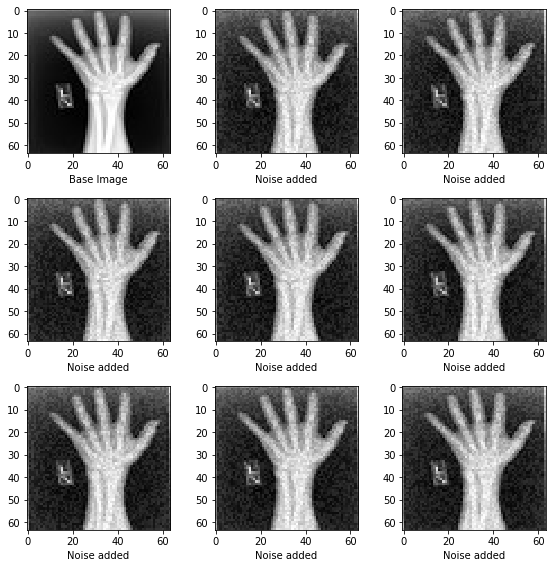

In [7]:
noiseStrength = 0.15
baseImage = Image.open(imageFiles[np.random.randint(6)][np.random.randint(8000)])
mp.subplots(3,3,figsize=(8,8))
mp.subplot(3,3,1)
mp.xlabel('Base Image')
mp.imshow(np.array(baseImage),cmap='gray',vmin=0,vmax=255)
for i in range(8):
    noise = np.random.random((imageWidth,imageHeight))
    arr = np.array(baseImage)*(1-noiseStrength)+255*noiseStrength*noise
    mp.subplot(3,3,i+2)
    mp.xlabel('Noise added')
    mp.imshow(arr,cmap='gray',vmin=0,vmax=255)
mp.tight_layout()
mp.show()

根据您之前的实验，为参数`maxRot`，`maxTrX`，`maxTrY`和`noiseStrength`选择具体的值，这些值会为图像添加一些差异而不会导致无法识别的更改。 下面的代码块将对随机选择的源图像使用组合的变换来扩充图像的每个类别，直到使每个类别的目标数量达到15000。

#### 注意！
该代码仅应运行一次，因为它将创建图像文件以扩充数据集。 使用上面的代码块尝试不同的参数值，然后再在下面设置它们并执行代码。 如果要重试，可以再次运行`rm`和`cp`命令。

在合并使用所有这些变换来扩大数据集之前，我们最后再定义一个像素值缩放函数，将来用于图像亮度的归一化。

### 代码块5

In [ ]:
## Run this if you want to remove augmented data
# !rm -r data/resized
# !cp -r data/resizedbackup data/resized

In [8]:
def normalizeImage(x):
    y = np.array(x)
    if(np.min(y) < np.max(y)):  # Assuming the image isn't empty, rescale so its values run from 0 to 255
        y = 255.0*(y - 1.0*np.min(y))/(1.0*np.max(y) - np.min(y))
    z = Image.fromarray(np.uint8(y))
    return z

In [9]:
numPerClass = 15000
maxRot = 30
maxTrX = 0.2
maxTrY = 0.2
noiseStrength = 0.15
randAff = tv.transforms.RandomAffine(maxRot,translate=(maxTrX,maxTrY),resample=Image.BICUBIC)

for i in range(numClass):
    print('Augmenting class',classNames[i])
    for j in range(numPerClass - numEach[i]):
        if j % 2000 == 0:
            print('Adding image number',j)
        imageID = np.random.randint(numEach[i])
        baseImage = Image.open(imageFiles[i][imageID])
        randImage = randAff(normalizeImage(baseImage))
        noise = np.random.random((imageWidth,imageHeight))
        arr = np.array(randImage)*(1-noiseStrength)+255*noiseStrength*noise
        finalImage = Image.fromarray(np.uint8(arr))
        fname = imageFiles[i][imageID][:-5]+str(j)+'a.jpeg'
        finalImage.save(fname)

Augmenting class CXR
Adding image number 0
Adding image number 2000
Adding image number 4000
Augmenting class ChestCT
Adding image number 0
Adding image number 2000
Adding image number 4000
Augmenting class Hand
Adding image number 0
Adding image number 2000
Adding image number 4000
Augmenting class BreastMRI
Adding image number 0
Adding image number 2000
Adding image number 4000
Adding image number 6000
Augmenting class HeadCT
Adding image number 0
Adding image number 2000
Adding image number 4000
Augmenting class AbdomenCT
Adding image number 0
Adding image number 2000
Adding image number 4000


现在，我们通过计算每个类中的图像数量来仔细检查是否已创建了预期的文件。

### 代码块6

In [10]:
imageFilesAug = [[os.path.join(dataDir,classNames[i],x) for x in os.listdir(os.path.join(dataDir,classNames[i]))]
              for i in range(numClass)]                       # list of all files
numEachAug = [len(imageFilesAug[i]) for i in range(numClass)]       # Count of each image class

for i in range(numClass):
    print("Category",classNames[i],"has",numEachAug[i],"images")

Category CXR has 15000 images
Category ChestCT has 15000 images
Category Hand has 15000 images
Category BreastMRI has 15000 images
Category HeadCT has 15000 images
Category AbdomenCT has 15000 images


多次运行下面的代码，以查看增强数据的示例输出。

### 代码块7

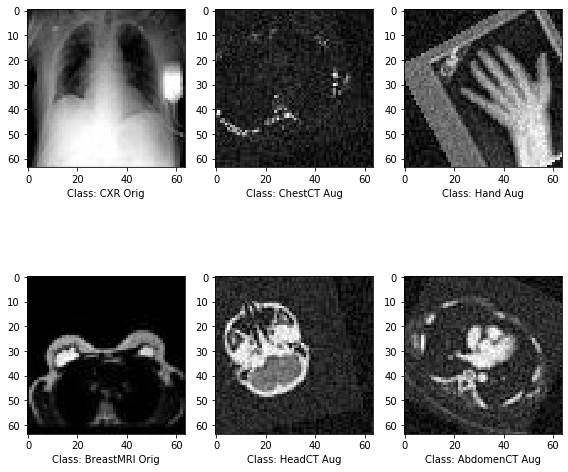

In [11]:
mp.subplots(3,2,figsize=(8,8))
for i in range(numClass):
    imageID = np.random.randint(numEachAug[i])
    im = Image.open(imageFilesAug[i][imageID])   # Randomly sample one image per class
    arr = np.array(im)
    mp.subplot(2,3,i+1)
    if imageFilesAug[i][imageID][-6] == 'a':
        imageType = ' Aug'
    else:
        imageType = ' Orig'
    mp.xlabel('Class: '+classNames[i]+imageType)
    mp.imshow(arr,cmap='gray',vmin=0,vmax=255)
mp.tight_layout()
mp.show()

在下面的单元格中，我们将使用增强数据和原始数据共同创建一个新的数据集和一个主张量，然后将其切分成训练、验证和测试集。

### 代码块8

In [12]:
toTensor = tv.transforms.ToTensor()
def scaleImage(x):          # Pass a PIL image, return a tensor
    y = toTensor(x)
    if(y.min() < y.max()):  # Assuming the image isn't empty, rescale so its values run from 0 to 1
        y = (y - y.min())/(y.max() - y.min()) 
    z = y - y.mean()        # Subtract the mean value of the image
    return z

In [13]:
imageFilesList = []               # Created an un-nested list of filenames
imageClass = []                   # The labels -- the type of each individual image in the list

imageFilesAug = [[os.path.join(dataDir,classNames[i],x) for x in os.listdir(os.path.join(dataDir,classNames[i]))]
              for i in range(numClass)]
for i in range(numClass):
    imageFilesList.extend(imageFilesAug[i])
    imageClass.extend([i]*numEachAug[i])
numTotalAug = np.sum(numEachAug)

# Rescale augmented dataset and create tensors
imageTensor = torch.stack([scaleImage(Image.open(x)) for x in imageFilesList])  # Load, scale, and stack image (X) tensor
classTensor = torch.tensor(imageClass)  # Create label (Y) tensor
print("Rescaled min pixel value = {:1.3}; Max = {:1.3}; Mean = {:1.3}"
      .format(imageTensor.min().item(),imageTensor.max().item(),imageTensor.mean().item()))

Rescaled min pixel value = -0.786; Max = 0.972; Mean = -5.2e-07


### 代码块9

In [ ]:
validFrac = 0.1   # Define the fraction of images to move to validation dataset
testFrac = 0.1    # Define the fraction of images to move to test dataset
validList = []
testList = []
trainList = []
trainX = []

for i in range(numTotalAug):
    rann = np.random.random() # Randomly reassign images
    if rann < validFrac:
        validList.append(i)
    elif rann < testFrac + validFrac:
        testList.append(i)
    else:
        trainList.append(i)
        
nTrainAug = len(trainList)  # Count the number in each set
nValidAug = len(validList)
nTestAug = len(testList)
print("Training images =",nTrainAug,"Validation =",nValidAug,"Testing =",nTestAug)

trainIds = torch.tensor(trainList)    # Slice the big image and label tensors up into
validIds = torch.tensor(validList)    #       training, validation, and testing tensors
testIds = torch.tensor(testList)
trainX = imageTensor[trainIds,:,:,:]
trainY = classTensor[trainIds]
validX = imageTensor[validIds,:,:,:]
validY = classTensor[validIds]
testX = imageTensor[testIds,:,:,:]
testY = classTensor[testIds]

因为我们在新的Python笔记本中，所以我们必须重新定义MedNet架构。

### 代码块10

In [ ]:
class MedNet(nn.Module):
    def __init__(self,xDim,yDim,numC): # Pass image dimensions and number of labels when initializing a model   
        super(MedNet,self).__init__()  # Extends the basic nn.Module to the MedNet class
        # The parameters here define the architecture of the convolutional portion of the CNN. Each image pixel
        # has numConvs convolutions applied to it, and convSize is the number of surrounding pixels included
        # in each convolution. Lastly, the numNodesToFC formula calculates the final, remaining nodes at the last
        # level of convolutions so that this can be "flattened" and fed into the fully connected layers subsequently.
        # Each convolution makes the image a little smaller (convolutions do not, by default, "hang over" the edges
        # of the image), and this makes the effective image dimension decreases.
        
        numConvs1 = 5
        convSize1 = 7
        numConvs2 = 10
        convSize2 = 7
        numNodesToFC = numConvs2*(xDim-(convSize1-1)-(convSize2-1))*(yDim-(convSize1-1)-(convSize2-1))

        # nn.Conv2d(channels in, channels out, convolution height/width)
        # 1 channel -- grayscale -- feeds into the first convolution. The same number output from one layer must be
        # fed into the next. These variables actually store the weights between layers for the model.
        
        self.cnv1 = nn.Conv2d(1, numConvs1, convSize1)
        self.cnv2 = nn.Conv2d(numConvs1, numConvs2, convSize2)

        # These parameters define the number of output nodes of each fully connected layer.
        # Each layer must output the same number of nodes as the next layer begins with.
        # The final layer must have output nodes equal to the number of labels used.
        
        fcSize1 = 400
        fcSize2 = 80
        
        # nn.Linear(nodes in, nodes out)
        # Stores the weights between the fully connected layers
        
        self.ful1 = nn.Linear(numNodesToFC,fcSize1)
        self.ful2 = nn.Linear(fcSize1, fcSize2)
        self.ful3 = nn.Linear(fcSize2,numC)
        
    def forward(self,x):
        # This defines the steps used in the computation of output from input.
        # It makes uses of the weights defined in the __init__ method.
        # Each assignment of x here is the result of feeding the input up through one layer.
        # Here we use the activation function elu, which is a smoother version of the popular relu function.
        
        x = F.elu(self.cnv1(x)) # Feed through first convolutional layer, then apply activation
        x = F.elu(self.cnv2(x)) # Feed through second convolutional layer, apply activation
        x = x.view(-1,self.num_flat_features(x)) # Flatten convolutional layer into fully connected layer
        x = F.elu(self.ful1(x)) # Feed through first fully connected layer, apply activation
        x = F.elu(self.ful2(x)) # Feed through second FC layer, apply output
        x = self.ful3(x)        # Final FC layer to output. No activation, because it's used to calculate loss
        return x

    def num_flat_features(self, x):  # Count the individual nodes in a layer
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

最后，我们实例化一个新模型并在新的数据集上对其进行训练。

In [ ]:
model_aug = MedNet(imageWidth,imageHeight,numClass).to(dev)

In [ ]:
learnRate = 0.01          # Define a learning rate.
maxEpochs = 20            # Maximum training epochs
t2vRatio = 1.2            # Maximum allowed ratio of validation to training loss
t2vEpochs = 3             # Number of consecutive epochs before halting if validation loss exceeds above limit
batchSize = 300           # Batch size. Going too large will cause an out-of-memory error.
trainBats = nTrainAug // batchSize       # Number of training batches per epoch. Round down to simplify last batch
validBats = nValidAug // batchSize       # Validation batches. Round down
testBats = -(-nTestAug // batchSize)     # Testing batches. Round up to include all
CEweights = torch.zeros(numClass)     # This takes into account the imbalanced dataset.
for i in trainY.tolist():             #      By making rarer images count more to the loss, 
    CEweights[i].add_(1)              #      we prevent the model from ignoring them.
CEweights = 1. / CEweights.clamp_(min=1.)                     # Weights should be inversely related to count
CEweights = (CEweights * numClass / CEweights.sum()).to(dev)  # The weights average to 1
opti = om.SGD(model_aug.parameters(), lr = learnRate)   # Initialize an optimizer


for i in range(maxEpochs):
    model_aug.train()                     # Set model to training mode
    epochLoss = 0.
    permute = torch.randperm(nTrainAug)  # Shuffle data to randomize batches
    trainX = trainX[permute,:,:,:]
    trainY = trainY[permute]
    for j in range(trainBats):        # Iterate over batches
        opti.zero_grad()              # Zero out gradient accumulated in optimizer
        batX = trainX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)   # Slice shuffled data into batches
        batY = trainY[j*batchSize:(j+1)*batchSize].to(dev)         # .to(dev) moves these batches to the GPU
        yOut = model_aug(batX)            # Evalute predictions
        loss = F.cross_entropy(yOut, batY, weight=CEweights)        # Compute loss
        epochLoss += loss.item()      # Add loss
        loss.backward()               # Backpropagate loss
        opti.step()                   # Update model weights using optimizer
    validLoss = 0.
    permute = torch.randperm(nValidAug)  # We go through the exact same steps, without backprop / optimization
    validX = validX[permute,:,:,:]    # in order to evaluate the validation loss
    validY = validY[permute]
    model_aug.eval()                      # Set model to evaluation mode
    with torch.no_grad():             # Temporarily turn off gradient descent
        for j in range(validBats):
            opti.zero_grad()
            batX = validX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
            batY = validY[j*batchSize:(j+1)*batchSize].to(dev)
            yOut = model_aug(batX)
            validLoss += F.cross_entropy(yOut, batY, weight=CEweights).item()
    epochLoss /= trainBats            # Average loss over batches and print
    validLoss /= validBats
    print("Epoch = {:-3}; Training loss = {:.4f}; Validation loss = {:.4f}".format(i,epochLoss,validLoss))
    if validLoss > t2vRatio * epochLoss:
        t2vEpochs -= 1                # Test if validation loss exceeds halting threshold
        if t2vEpochs < 1:
            print("Validation loss too high; halting to prevent overfitting")
            break

## 模型验证和比较

让我们生成一个新的混淆矩阵，并将其与以前的模型进行比较。

### 代码块11

In [ ]:
model_aug.eval()
with torch.no_grad():
    permute = torch.randperm(nTestAug)                     # Shuffle test data
    testX = testX[permute,:,:,:]
    testY = testY[permute]
    pred_aug = []

    for j in range(testBats):                           # Iterate over test batches
        batX = testX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
        batY = testY[j*batchSize:(j+1)*batchSize].to(dev)
        yOut = model_aug(batX)                              # Pass test batch through model
        predict = yOut.max(1)[1].cpu().numpy()
        pred_aug = np.concatenate((pred_aug, predict))

# Augmented confusion matrix
class_names = ['BreastMRI', 'Hand', 'HeadCT', 'CXR', 'ChestCT', 'AbdomenCT']
print("Augmented Accuracy = ", accuracy_score(pred_aug, testY))
cm_aug = confusion_matrix(pred_aug, testY)
_ = plot_confusion_matrix(cm_aug, colorbar=True, class_names=class_names)

## 结论

您应该会看到98％以上的准确性。 您可能会注意到准确性比在原始数据集上获得的模型稍差。 请记住，我们的目标是<b>相似</b>而不是相同的准确性。 只要我们处于相同的性能范围内，我们就可以确定我们未在训练集中引入任何会影响模型的泛化能力的变形。 由于每个数据集在大小，目标和类分布方面都不同，因此没有一个单一的方法或一组参数能确保性能一定会提高。相反，我们可以验证各种实验性的技术，比如上面执行的可被验证的数据增强，然后将它们转换到较小的数据集作为起点。

您可随时继续更换数据增强的参数，来重新创建数据集并重新训练网络几次。 您还可以返回上一个笔记本中的混淆矩阵以比较结果。

祝好运！

<img src="images/DLI Header.png" alt="Header" style="width: 400px;"/>